In [1]:
from catboost import CatBoostClassifier, Pool
import timeit
import random
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import cv

In [2]:
def col_info(col_name):
    print('Number of Nan values: {}'.format(df_stat[col_name].isnull().sum()))
    display(pd.DataFrame(df_stat[col_name].value_counts()))
    print("Values that occur more than 100 times in a column:", (df_stat[col_name].value_counts()>100).sum())
    df_stat.loc[:, [col_name]].info()
    df_stat[col_name].hist()

### Getting data from two csv files and merging into one dataframe

In [3]:
df_match = pd.read_csv('match.csv')
df_players = pd.read_csv('players.csv')

In [4]:
display(df_match.head(5))
display(df_players.head(5))

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,...,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,...,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_stat = df_match[['match_id', 'radiant_win']]

In [6]:
pivot = pd.pivot_table(df_players,
               index=['match_id'],
              columns=['player_slot'],
              values=['hero_id'])

In [7]:
df_stat['0'] = pivot['hero_id'][0]
df_stat['1'] = pivot['hero_id'][1]
df_stat['2'] = pivot['hero_id'][2]
df_stat['3'] = pivot['hero_id'][3]
df_stat['4'] = pivot['hero_id'][4]
df_stat['128'] = pivot['hero_id'][128]
df_stat['129'] = pivot['hero_id'][129]
df_stat['130'] = pivot['hero_id'][130]
df_stat['131'] = pivot['hero_id'][131]
df_stat['132'] = pivot['hero_id'][132]

C:\Users\his19\AppData\Local\Temp/ipykernel_8212/2451914949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat['0'] = pivot['hero_id'][0]
C:\Users\his19\AppData\Local\Temp/ipykernel_8212/2451914949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat['1'] = pivot['hero_id'][1]
C:\Users\his19\AppData\Local\Temp/ipykernel_8212/2451914949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [8]:
display(df_stat)

,match_id,radiant_win,0,1,2,3,4,128,129,130,131,132
0,0,True,86,51,83,11,67,106,102,46,7,73
1,1,False,7,82,71,39,21,73,22,5,67,106
2,2,False,51,109,9,41,27,38,7,10,12,85
3,3,False,50,44,32,26,39,78,19,31,40,47
4,4,True,8,39,55,87,69,101,100,22,67,21
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,True,73,86,21,20,14,32,7,109,35,112
49996,49996,True,93,74,100,32,85,36,1,112,60,71
49997,49997,True,100,68,75,39,44,28,102,21,9,23
49998,49998,True,56,50,2,72,30,46,7,29,44,3


Number of Nan values: 0


,0
21,2159
11,1926
74,1240
7,1175
28,1149
...,...
78,90
89,88
103,65
66,52


Values that occur more than 100 times in a column: 104
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


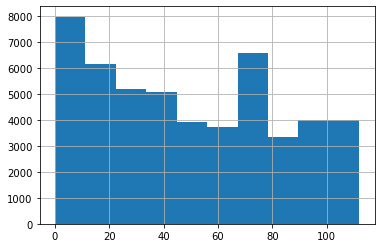

In [9]:
col_info('0')

Number of Nan values: 0


,1
21,2053
11,1744
74,1174
28,1118
7,1094
...,...
78,91
92,87
103,80
66,55


Values that occur more than 100 times in a column: 106
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


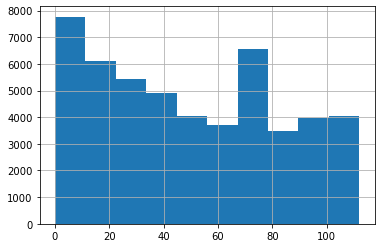

In [10]:
col_info('1')

Number of Nan values: 0


,2
21,2078
11,1825
7,1193
74,1167
100,1042
...,...
111,84
80,82
92,75
66,56


Values that occur more than 100 times in a column: 103
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   2       50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


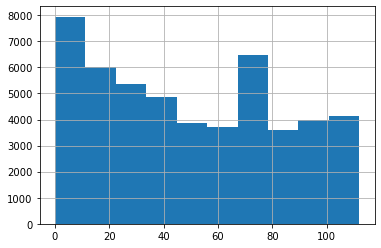

In [11]:
col_info('2')

Number of Nan values: 0


,3
21,2061
11,1816
7,1174
74,1130
28,1116
...,...
103,90
89,87
78,86
66,63


Values that occur more than 100 times in a column: 106
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   3       50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


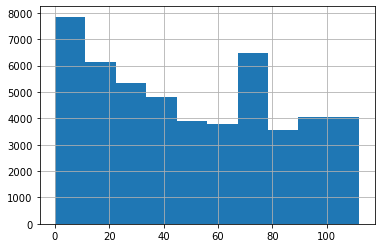

In [12]:
col_info('3')

Number of Nan values: 0


,4
21,1973
11,1697
7,1202
74,1113
39,1037
...,...
92,93
78,91
103,88
66,44


Values that occur more than 100 times in a column: 100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   4       50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


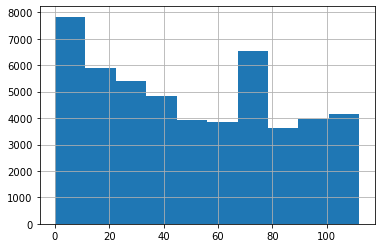

In [13]:
col_info('4')

Number of Nan values: 0


,128
21,2141
11,1730
74,1238
39,1181
8,1119
...,...
58,89
78,87
103,82
66,57


Values that occur more than 100 times in a column: 106
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   128     50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


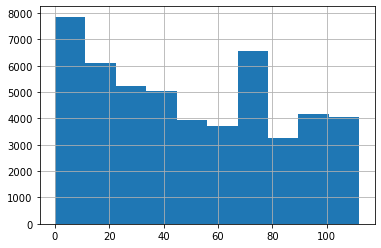

In [14]:
col_info('128')

Number of Nan values: 0


,129
21,2135
11,1536
28,1165
74,1160
7,1089
...,...
58,89
111,89
103,80
66,50


Values that occur more than 100 times in a column: 104
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   129     50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


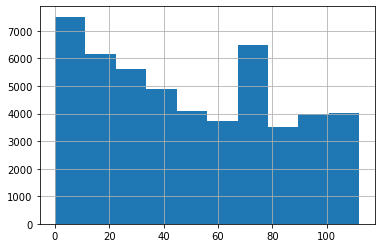

In [15]:
col_info('129')

Number of Nan values: 0


,130
21,2098
11,1688
28,1181
74,1173
7,1123
...,...
80,92
77,88
78,87
66,67


Values that occur more than 100 times in a column: 104
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   130     50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


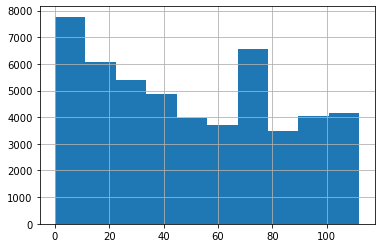

In [16]:
col_info('130')

Number of Nan values: 0


,131
21,2062
11,1562
74,1173
28,1151
7,1106
...,...
77,87
78,83
103,83
66,64


Values that occur more than 100 times in a column: 103
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   131     50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


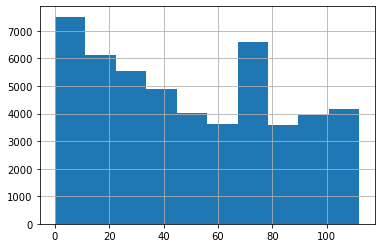

In [17]:
col_info('131')

Number of Nan values: 0


,132
21,2121
11,1483
28,1121
74,1108
7,1096
...,...
92,93
103,89
80,73
66,71


Values that occur more than 100 times in a column: 104
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   132     50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


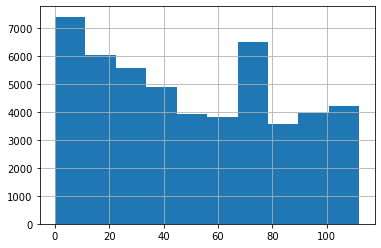

In [18]:
col_info('132')

In [19]:
df_stat = df_stat.drop(df_stat[(df_stat['0'] == 0) | (df_stat['1'] == 0) 
                               | (df_stat['2'] == 0) | (df_stat['3'] == 0) 
                               | (df_stat['4'] == 0) | (df_stat['128'] == 0) 
                               | (df_stat['129'] == 0) | (df_stat['130'] == 0) 
                               | (df_stat['131'] == 0) | (df_stat['132'] == 0)].index)

In [20]:
df_stat = df_stat.reset_index(drop=True)

In [21]:
display(df_stat)

,match_id,radiant_win,0,1,2,3,4,128,129,130,131,132
0,0,True,86,51,83,11,67,106,102,46,7,73
1,1,False,7,82,71,39,21,73,22,5,67,106
2,2,False,51,109,9,41,27,38,7,10,12,85
3,3,False,50,44,32,26,39,78,19,31,40,47
4,4,True,8,39,55,87,69,101,100,22,67,21
...,...,...,...,...,...,...,...,...,...,...,...,...
49960,49995,True,73,86,21,20,14,32,7,109,35,112
49961,49996,True,93,74,100,32,85,36,1,112,60,71
49962,49997,True,100,68,75,39,44,28,102,21,9,23
49963,49998,True,56,50,2,72,30,46,7,29,44,3


Number of Nan values: 0


,4
21,1972
11,1695
7,1202
74,1112
39,1035
...,...
89,94
92,93
78,91
103,88


Values that occur more than 100 times in a column: 100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49965 entries, 0 to 49964
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   4       49965 non-null  int64
dtypes: int64(1)
memory usage: 390.5 KB


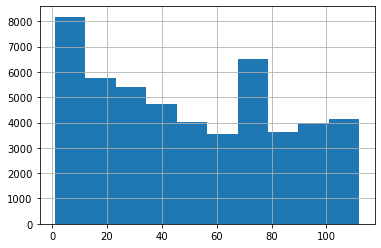

In [22]:
col_info('4')

### For forecasting I use catboost open source gradient boosting library

In [23]:
df_train = df_stat.drop(columns = ['match_id'])

In [24]:
X_data_train = df_train.drop(columns = ['radiant_win'])
y_data_train = df_train['radiant_win']

### First draft

In [25]:
RANDOM_SEED = 42
X_train, X_valid, y_train, y_valid = train_test_split(X_data_train, y_data_train,
                                               random_state=RANDOM_SEED,
                                               test_size=0.2)

In [26]:
def train_on_cpu():  
  model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    task_type='CPU',
      custom_loss=['AUC', 'Accuracy']
  )
  
  model.fit(
      X_train, y_train,
      eval_set=(X_valid, y_valid),
      verbose=False,
      plot=True
  );     
      
gpu_time = timeit.timeit('train_on_cpu()', 
                         setup="from __main__ import train_on_cpu", 
                         number=1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Cross-validation

In [27]:
params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'custom_loss': ['AUC', 'Accuracy'],
    'learning_rate': 0.05,
    'task_type': 'CPU',
}

cv_data = cv(
    params = params,
    pool = Pool(X_data_train, label=y_data_train),
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.687373355
bestIteration = 795

Training on fold [1/5]

bestTest = 0.6886735937
bestIteration = 734

Training on fold [2/5]

bestTest = 0.6879376634
bestIteration = 713

Training on fold [3/5]

bestTest = 0.6881713824
bestIteration = 624

Training on fold [4/5]

bestTest = 0.6886144621
bestIteration = 795



### Since players can choose heroes in different sequences, I decided to add data by shuffling the heroes into teams for each game. But if there are two teams of five players, the total number of combinations is 14400. Generation of new data and training on them will take a very long time, so I did a parallel mixing of teams and took 10% of random combinations of heroes. And so I increased the original data by 12 times.

In [28]:
df_team1 = df_stat[['0','1','2','3','4']]
df_team2 = df_stat[['128','129','130','131','132']]

In [29]:
from itertools import permutations

df_team1_pmt = pd.DataFrame()
df_team2_pmt = pd.DataFrame()
df_train_pmt = pd.DataFrame(columns=('radiant_win','0','1','2','3','4','128','129','130','131','132'))
df_test = pd.DataFrame()

#df_test = df_train.head(10)

for i in range(df_train.shape[0]):
    df_team1_tmp = pd.DataFrame()
    df_team2_tmp = pd.DataFrame()
    df_radiant_stat = pd.DataFrame()
    
    for j in permutations(df_team1.iloc[i]):
        df_t = pd.DataFrame(j).T
        df_team1_tmp = df_team1_tmp.append(df_t)

    for j in permutations(df_team2.iloc[i]):
        df_t = pd.DataFrame(j).T
        df_team2_tmp = df_team2_tmp.append(df_t)

    df_team1_tmp = df_team1_tmp.sample(frac=0.1, replace=True, random_state=42)
    df_team1_tmp.columns = ['0','1','2','3','4']
    
    df_team2_tmp = df_team2_tmp.sample(frac=0.1, replace=True, random_state=42)
    df_team2_tmp.columns = ['128','129','130','131','132']
    
    df_pmt_tmp = pd.concat([df_team1_tmp, df_team2_tmp], axis=1)
    
    df_train_pmt = df_train_pmt.append(df_pmt_tmp)
    df_train_pmt = df_train_pmt.fillna(df_train['radiant_win'][i])
    
display(df_train_pmt)

,radiant_win,0,1,2,3,4,128,129,130,131,132
0,True,67,51,86,83,11,73,102,106,46,7
0,True,83,86,11,67,51,46,106,7,73,102
0,True,11,67,51,86,83,7,73,102,106,46
0,True,86,11,83,51,67,106,7,46,102,73
0,True,67,51,11,86,83,73,102,7,106,46
...,...,...,...,...,...,...,...,...,...,...,...
0,False,94,21,68,19,35,100,53,90,9,73
0,False,21,19,94,68,35,53,9,100,90,73
0,False,35,19,21,94,68,73,9,53,100,90
0,False,35,68,19,94,21,73,90,9,100,53


In [30]:
X_data_train_pmt = df_train_pmt.drop(columns = ['radiant_win'])
y_data_train_pmt = df_train_pmt['radiant_win']

In [31]:
params = {
    'loss_function': 'Logloss',
    'iterations': 10000,
    'custom_loss': ['AUC', 'Accuracy'],
    'learning_rate': 0.5,
    'task_type': 'CPU',
}

cv_data = cv(
    params = params,
    pool = Pool(X_data_train_pmt, label=y_data_train_pmt),
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6489213231
bestIteration = 6056

Training on fold [1/5]

bestTest = 0.6507072448
bestIteration = 5114

Training on fold [2/5]

bestTest = 0.6491011518
bestIteration = 7452

Training on fold [3/5]

bestTest = 0.6471893633
bestIteration = 9218

Training on fold [4/5]

bestTest = 0.6477426838
bestIteration = 5616



### It turned out to achieve a result of 66% accuracy. Because victory depends on many parameters, and not just on the selected heroes, I consider this a good result. If we develop this topic further, we can add dependence on the use of heroes by specific players, as well as statistics on team victories.

## Analysis of hero combinations

In [32]:
df_teams = df_team1
new_cols = {x: y for x, y in zip(df_team2.columns, df_team1.columns)}
df_teams = df_teams.append(df_team2.rename(columns=new_cols))
display(df_teams)

,0,1,2,3,4
0,86,51,83,11,67
1,7,82,71,39,21
2,51,109,9,41,27
3,50,44,32,26,39
4,8,39,55,87,69
...,...,...,...,...,...
49960,32,7,109,35,112
49961,36,1,112,60,71
49962,28,102,21,9,23
49963,46,7,29,44,3


In [33]:
df_teams = df_teams.astype({"0": "Int64"})
df_teams = df_teams.astype({"1": "Int64"})
df_teams = df_teams.astype({"2": "Int64"})
df_teams = df_teams.astype({"3": "Int64"})
df_teams = df_teams.astype({"4": "Int64"})
df_teams.dtypes

0    Int64
1    Int64
2    Int64
3    Int64
4    Int64
dtype: object

In [34]:
import numpy as np
import pandas as pd


from itertools import combinations

cc = list(combinations(df_teams.columns,2))

t = np.concatenate([np.sort(df_teams.loc[:, c], axis=1) for c in cc])
t_plus = np.concatenate([np.sort(df_teams.loc[:, c], axis=1).sum(1) for c in cc])

#s = pd.Series(t)
#res = s.groupby(s).size().nsmallest(10)

#display(res)

In [35]:
import time 

#s = pd.Series()
lista = []

for i in range(len(t)):
    lista.append(int(str(t[i][0]) + str(t[i][1])))
    time.sleep(0.001)
    
#print(t)
print(lista)


#res = s.groupby(s).size().nlargest(10)

#display(res)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

